In [23]:
# Cosas por hacer:
#    - Igual al final se pueden poner más imágenes o espectros, aunque en el tutorial no aparezca.
#    - La celda del espectro no funciona
#    - No se puede descargar el fichero attitude.fits

In [1]:
import copy
import glob
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import time
import tempfile
import shutil, shlex


from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from datetime import datetime
from funcs import *
from simulation_imports import *
from subprocess import check_call, STDOUT
from xspec import Xset, Plot, AllData, ModelManager, Spectrum, Model, AllModels, Fit

plt.style.use(astropy_mpl_style)


In [2]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
SIXTE = os.environ["SIXTE"]
xmldir = "{}/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row".format(SIXTE)

xml0="{}/ld_wfi_ff_chip0.xml".format(xmldir)
xml1="{}/ld_wfi_ff_chip1.xml".format(xmldir)
xml2="{}/ld_wfi_ff_chip2.xml".format(xmldir)
xml3="{}/ld_wfi_ff_chip3.xml".format(xmldir)
#xmldir="./xmldir"

### Observations with eRosita

#### Pointed observation

In [3]:
# Using the simput file downloaded from  http://www.sternwarte.uni-erlangen.de/research/sixte/simput/athenacrab_flux0001000muCrab.simput.tgz


simput_eRosita = 'athenacrab_flux0001000muCrab.simput'
evt_eRosita_merged = 'athenacrab_merged.fits'

# Create the string used in the ftmerge
ftmerge_comm = ['athenacrab_ccd{}_evt.fits'.format(i) for i in range(1, 8)]
ftmerge_comm = ','.join(ftmerge_comm)

rewrite = True
if rewrite:
    if os.path.exists(evt_eRosita_merged):
        os.remove(evt_eRosita_merged)
    run_comm('erosim Prefix=athenacrab_ Simput={} Exposure=1000 Ra=0 Dec=0 clobber=yes'.format(simput_eRosita), 'Simulating eRosita observation')
    run_comm('ftmerge {} {}'.format(ftmerge_comm, evt_eRosita_merged))
else:
    print('Event file {} already exists, it wont be overwritten'.format(evt_eRosita_merged))

Simulating eRosita observation
erosim Prefix=athenacrab_ Simput=athenacrab_flux0001000muCrab.simput Exposure=1000 Ra=0 Dec=0 clobber=yes

ftmerge athenacrab_ccd1_evt.fits,athenacrab_ccd2_evt.fits,athenacrab_ccd3_evt.fits,athenacrab_ccd4_evt.fits,athenacrab_ccd5_evt.fits,athenacrab_ccd6_evt.fits,athenacrab_ccd7_evt.fits athenacrab_merged.fits


Event file athenacrab_img.fits already exists, it wont be overwritten
Opening image
xdg-open imgs/imgev_zoom_eRosita.png


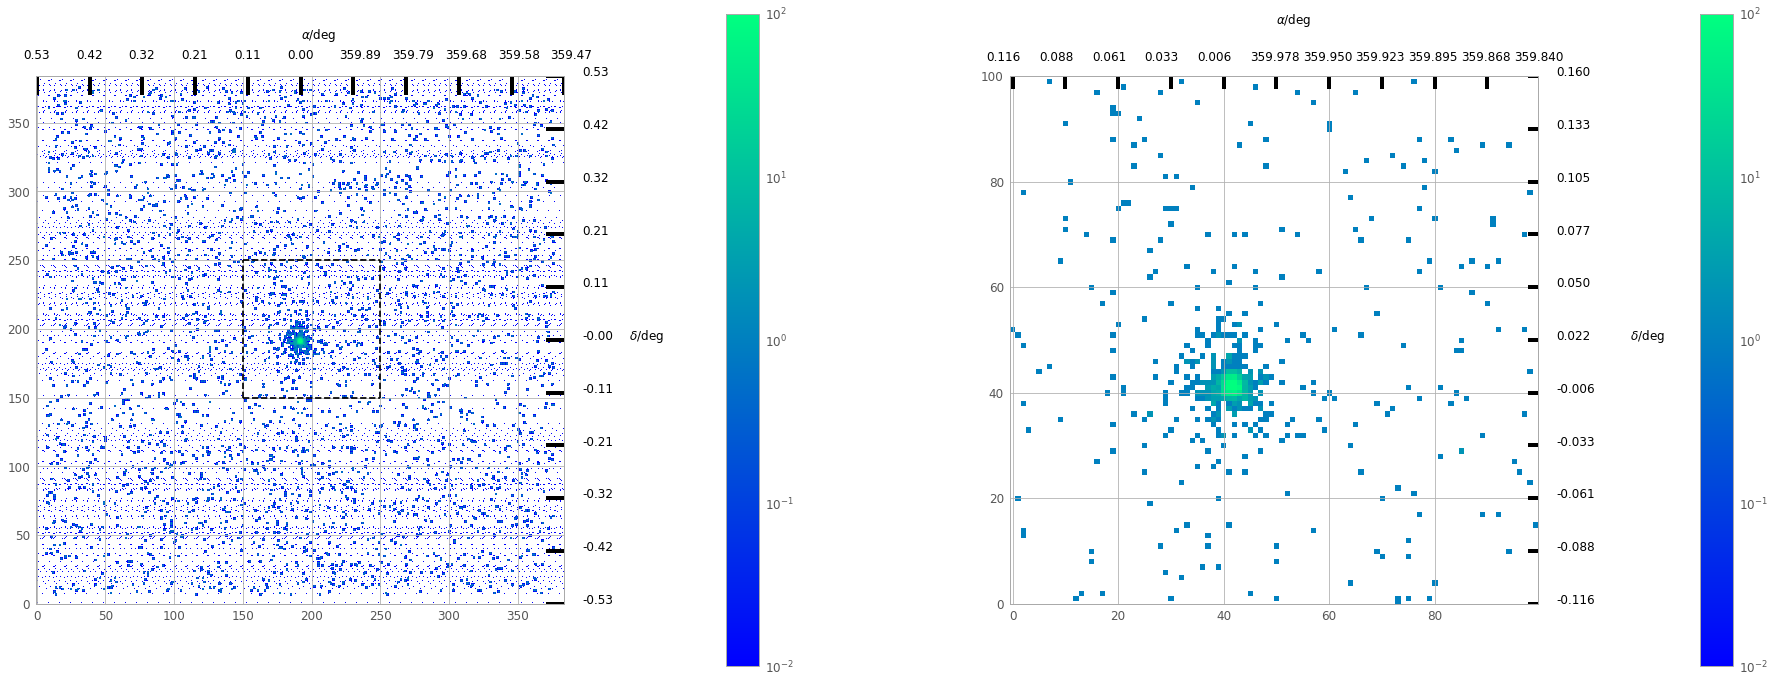

In [21]:
img_eRosita = 'athenacrab_img.fits'

rewrite = False
if rewrite:
    run_comm('imgev EvtFile=athenacrab_ccd1_evt.fits Image={} CoordinateSystem=0 Projection=TAN CUNIT1=deg CUNIT2=deg NAXIS1=384 NAXIS2=384'.format(img_eRosita) +
             ' CRVAL1=0.0 CRVAL2=0.0 CDELT1=-0.0027778 CDELT2=0.00277778 CRPIX1=192.5 CRPIX2=192.5 clobber=yes', 'Creating eRosita image')
else:
    print('Event file {} already exists, it wont be overwritten'.format(img_eRosita))



image_data = fits.getdata(img_eRosita, ext=0)
image_data2 = image_data[150:250, 150:250]

fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(16*2,6*2))
axs = _axs.flatten()
axs[0].plot([532, 532], [0,len(image_data)], 'k-')
axs[0].plot([0,len(image_data)], [532, 532],  'k-')

sq_dwl = np.array((0.53, -0.53))
sq_upr = np.array((359.47, 0.53))

draw_second_axis(fig, axs, sq_downleft=sq_dwl, sq_upright=sq_upr, ln=384, mov_ra=10, mov_dec=0, lon_lines=12, num_lines=10,
                mov_x_text=[0, 27], mov_y_text=[47, 0], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=0, dist_txt=13, zero_between=True, display_format='.2f')

sq1, sq2 = get_zoom_coord(sq_dwl, sq_upr, 384, x=[150, 250], y=[150, 250], zero_between=True)

draw_second_axis(fig, axs, sq_downleft=sq1, sq_upright=sq2, ln=len(image_data2[:, 0]), mov_ra=5, mov_dec=0, lon_lines=2, num_lines=10,
                mov_x_text=[0, 10], mov_y_text=[17, 0], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=1, dist_txt=3, zero_between=True, display_format='.3f')

axs[0].set_ylim(0, len(image_data))
axs[0].plot([150, 250], [150, 150], 'k--')
axs[0].plot([150, 250], [250, 250], 'k--')
axs[0].plot([150, 150], [150, 250], 'k--')
axs[0].plot([250, 250], [150, 250], 'k--')

axs[1].set_ylim(0, len(image_data2))

cmap = plt.cm.winter
im = axs[0].imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=0.01, vmax=100))
fig.colorbar(im,ax=axs[0], pad=0.2)

im = axs[1].imshow(image_data2, cmap=cmap, norm=colors.LogNorm(vmin=0.01, vmax=100))
fig.colorbar(im,ax=axs[1], pad=0.2)

In [15]:
# Create spectrum
spec_file = 'eRosita_spec.pha'
rewrite = True
if rewrite:
    if os.path.exists(spec_file):
        os.remove(spec_file)
    run_comm("makespec EvtFile={} Spectrum={} clobber=yes RSPPath={}".format(evt_eRosita_merged, spec_file, xmldir), 'Generating spectrum')
else:
    print('Spec file {} already exists, it will not be overwritten'.format(spec_file))

    
Plot.device = '/null'
AllData.clear()
AllModels.clear()

Plot.device = "/xs"
Plot.xAxis="KeV"

# rebin spectral data

binspec = "eRosita_spec_rebin.pha"

rewrite = True
if rewrite:
    if os.path.exists(binspec):
            os.remove(binspec)
    comm = ("grppha infile={} outfile={} clobber=yes comm='group min 20 & exit'".format(spec_file, binspec))    
    run_comm(comm, "Rebinning spectrum")
else:
    print("Rebin file ({}) already exists: it will not be overwritten".format(binspec))

AllData.clear()
s1 = Spectrum(spec_file)
s1.ignore("**-1.0")
s1.ignore("11.0-**")
s1.ignore("bad")
Plot("ldata")

Generating spectrum
makespec EvtFile=athenacrab_ccd1_evt.fits Spectrum=eRosita_spec.pha clobber=yes RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row
Command '['makespec', 'EvtFile=athenacrab_ccd1_evt.fits', 'Spectrum=eRosita_spec.pha', 'clobber=yes', 'RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row']' returned non-zero exit status 1.


CalledProcessError: Command '['makespec', 'EvtFile=athenacrab_ccd1_evt.fits', 'Spectrum=eRosita_spec.pha', 'clobber=yes', 'RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row']' returned non-zero exit status 1.

#### All-Sky survey

In [22]:
simput_eRosita = 'athenacrab_flux0001000muCrab.simput'
evt_eRosita_allsky_merged = 'athenacrab_allsky_merged.fits'

# Create the string used in the ftmerge
ftmerge_comm = ['athenacrab_allsky_ccd{}_evt.fits'.format(i) for i in range(1, 8)]
ftmerge_comm = ','.join(ftmerge_comm)

rewrite = True
if rewrite:
    if os.path.exists(evt_eRosita_allsky_merged):
        os.remove(evt_eRosita_allsky_merged)
    run_comm('erosim Prefix=athenacrab_allsky_ Simput={} Exposure=10000 Ra=0 Dec=0 Attitude=attitude.fits TSTART=0.0 MJDREF=51543.875 clobber=yes'.format(simput_eRosita), 'Simulating eRosita observation')
    run_comm('ftmerge {} {}'.format(ftmerge_comm, evt_eRosita_allsky_merged))
else:
    print('Event file {} already exists, it wont be overwritten'.format(evt_eRosita_allsky_merged))




Simulating eRosita observation
erosim Prefix=athenacrab_allsky_ Simput=athenacrab_flux0001000muCrab.simput Exposure=10000 Ra=0 Dec=0 Attitude=attitude.fits TSTART=0.0 MJDREF=51543.875 clobber=yes
Command '['erosim', 'Prefix=athenacrab_allsky_', 'Simput=athenacrab_flux0001000muCrab.simput', 'Exposure=10000', 'Ra=0', 'Dec=0', 'Attitude=attitude.fits', 'TSTART=0.0', 'MJDREF=51543.875', 'clobber=yes']' returned non-zero exit status 1.


CalledProcessError: Command '['erosim', 'Prefix=athenacrab_allsky_', 'Simput=athenacrab_flux0001000muCrab.simput', 'Exposure=10000', 'Ra=0', 'Dec=0', 'Attitude=attitude.fits', 'TSTART=0.0', 'MJDREF=51543.875', 'clobber=yes']' returned non-zero exit status 1.

#### Simulating single sources in the All-Sky survey

In [ ]:
simput_eRosita = 'athenacrab_flux0001000muCrab.simput'
gti_file = 'athenacrab_single_allsky.fits'

rewrite = True
if rewrite:
    if os.path.exists(gti_file):
        os.remove(gti_file)
    run_comm('ero_vis GTIFile={} Simput={} Exposure=10000 Ra=0 Dec=0 Attitude=attitude.fits TSTART=0.0 dt=1.0 visibility_range=1.0 clobber=yes'.format(gti_file, simput_eRosita), 'Simulating eRosita observation')
else:
    print('Event file {} already exists, it wont be overwritten'.format(evt_eRosita_allsky_merged))


